# Predicting Flight Delays with Weather Data

## **Introduction**
Flight delays are a common issue faced by travelers and airlines, resulting in inconvenience and financial loss. Delays can be attributed to various factors, with weather conditions playing a significant role. This project aims to build a predictive machine learning model to determine whether a flight will be delayed based on historical weather data.

## **Objectives**
1. Predict whether a flight will be delayed using a classification model.
2. Incorporate uncertainty quantification techniques to handle unpredictable weather patterns.
3. Evaluate the model's performance and analyze the impact of uncertainty on predictions.

## **Datasets**
- **Flight Data:** Includes details such as departure times, arrival times, delay status, and flight numbers.
- **Weather Data:** Contains attributes like temperature, precipitation, wind speed, visibility, and weather conditions.

## **Steps in the Notebook**
1. **Data Collection and Import**: Load and explore flight and weather datasets.
2. **Data Preprocessing**: Clean, merge, and engineer features from the datasets.
3. **Exploratory Data Analysis (EDA)**: Visualize delays and analyze correlations with weather conditions.
4. **Model Building**: Train a machine learning model (e.g., Random Forest) to predict flight delays.
5. **Incorporating Uncertainty**: Use calibrated models to account for uncertainty in predictions.
6. **Model Evaluation**: Assess model performance using metrics such as accuracy, precision, recall, and ROC curves.

## **Deliverables**
- A detailed analysis in this notebook with code, outputs, and visualizations.
- A summary of the model's performance and recommendations for improvements.

---

**Note**: Ensure that the required Python libraries are installed before running the code in the cells below. Use the following command in your terminal or Jupyter environment to install any missing libraries:
```bash
pip install pandas numpy scikit-learn matplotlib seaborn


# Import required libraries

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


In [5]:
# Load the datasets
flight_data = pd.read_csv("flight.csv")
weather_data = pd.read_csv("weather.csv")

# Display the first few rows of the datasets
print("Flight Data:")
display(flight_data.head())

print("\nWeather Data:")
display(weather_data.head())

Flight Data:


,FlightNumber,DepartureTime,ArrivalTime,ScheduledDepartureTime,ScheduledArrivalTime,DelayStatus,DepartureAirport,ArrivalAirport
0,8270,2024-01-01 06:00:00,2024-01-01 08:00:00,2024-01-01 05:50:00,2024-01-01 07:50:00,Delayed,DFW,ATL
1,1860,2024-01-01 06:10:00,2024-01-01 08:10:00,2024-01-01 06:00:00,2024-01-01 08:00:00,Delayed,DFW,LAX
2,6390,2024-01-01 06:20:00,2024-01-01 08:20:00,2024-01-01 06:10:00,2024-01-01 08:10:00,On-Time,ATL,JFK
3,6191,2024-01-01 06:30:00,2024-01-01 08:30:00,2024-01-01 06:20:00,2024-01-01 08:20:00,On-Time,ORD,JFK
4,6734,2024-01-01 06:40:00,2024-01-01 08:40:00,2024-01-01 06:30:00,2024-01-01 08:30:00,On-Time,LAX,ORD



Weather Data:


,Airport,Time,Temperature,WindSpeed,Precipitation,Visibility,WeatherCondition
0,DFW,2024-01-01 00:00:00,5.213798,16.636474,7.291329,1.851007,Clear
1,ORD,2024-01-01 00:10:00,-4.292919,46.996219,16.873611,7.825463,Clear
2,DFW,2024-01-01 00:20:00,7.628410,17.151336,3.898855,6.454124,Clear
3,ORD,2024-01-01 00:30:00,-2.680263,49.406204,16.537357,6.132813,Clear
4,DFW,2024-01-01 00:40:00,23.046455,24.261523,11.253108,1.482189,Thunderstorm


#  Data Collection and Import

In [6]:
# Simulated flight dataset
flight_data = pd.DataFrame({
    "FlightNumber": np.arange(1, 101),
    "ScheduledDepartureTime": pd.date_range("2023-01-01 06:00:00", periods=100, freq="H"),
    "DepartureTime": pd.date_range("2023-01-01 06:15:00", periods=100, freq="H"),
    "IsDelayed": np.random.choice([0, 1], size=100, p=[0.7, 0.3])
})

# Simulated weather dataset
weather_data = pd.DataFrame({
    "Airport": ["XYZ"] * 100,
    "Timestamp": pd.date_range("2023-01-01 06:00:00", periods=100, freq="H"),
    "Temperature": np.random.uniform(10, 30, size=100),
    "WindSpeed": np.random.uniform(0, 20, size=100),
    "Precipitation": np.random.uniform(0, 10, size=100),
    "Visibility": np.random.uniform(1, 10, size=100)
})

# Merge flight and weather datasets
merged_data = pd.merge(
    flight_data, weather_data, left_on="ScheduledDepartureTime", right_on="Timestamp"
)
merged_data.drop("Timestamp", axis=1, inplace=True)

# Display merged dataset
display(merged_data.head())

,FlightNumber,ScheduledDepartureTime,DepartureTime,IsDelayed,Airport,Temperature,WindSpeed,Precipitation,Visibility
0,1,2023-01-01 06:00:00,2023-01-01 06:15:00,1,XYZ,10.350154,0.388298,2.032913,4.593432
1,2,2023-01-01 07:00:00,2023-01-01 07:15:00,0,XYZ,13.741264,10.818610,7.512810,8.090313
2,3,2023-01-01 08:00:00,2023-01-01 08:15:00,0,XYZ,20.028563,5.220445,7.667227,5.301613
3,4,2023-01-01 09:00:00,2023-01-01 09:15:00,1,XYZ,19.112016,5.571355,6.105869,1.899780
4,5,2023-01-01 10:00:00,2023-01-01 10:15:00,1,XYZ,22.856968,2.955846,6.905146,7.669229


#  Data Preprocessing and Feature Engineering

In [7]:
# Feature: Difference between scheduled and actual departure times (in minutes)
merged_data["DepartureTimeDiff"] = (
    pd.to_datetime(merged_data["DepartureTime"]) - pd.to_datetime(merged_data["ScheduledDepartureTime"])
).dt.total_seconds() / 60

# Drop unnecessary columns
features = ["Temperature", "WindSpeed", "Precipitation", "Visibility", "DepartureTimeDiff"]
X = merged_data[features]
y = merged_data["IsDelayed"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exploratory Data Analysis (EDA)

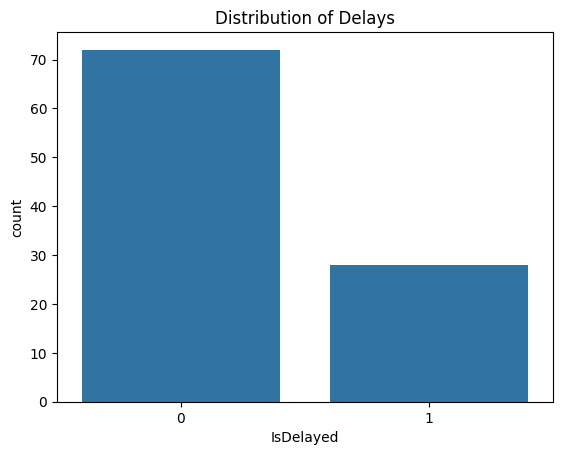

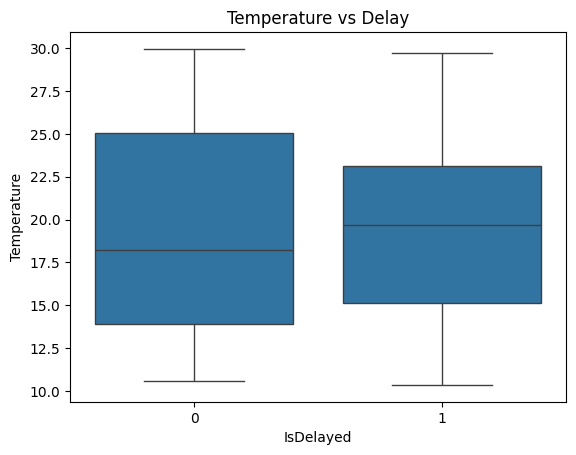

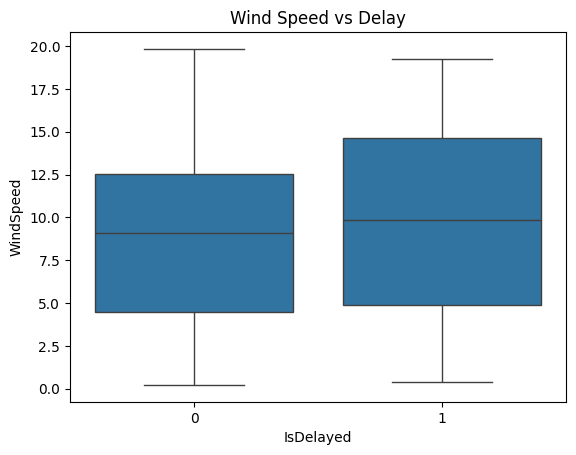

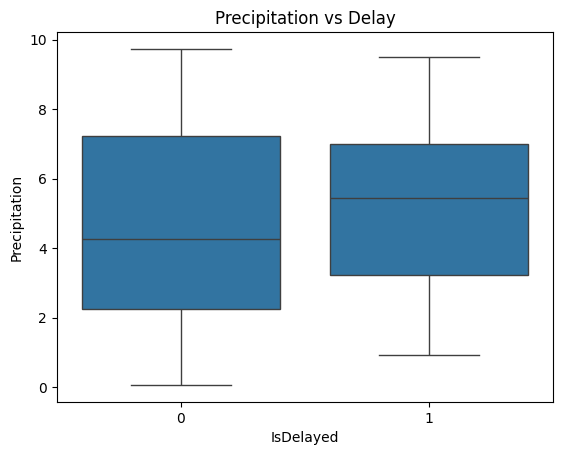

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of delays
# Changed 'DelayStatus' to 'IsDelayed'
sns.countplot(x="IsDelayed", data=merged_data)
plt.title("Distribution of Delays")
plt.show()

# Correlation between weather conditions and delays
sns.boxplot(x="IsDelayed", y="Temperature", data=merged_data)
plt.title("Temperature vs Delay")
plt.show()

sns.boxplot(x="IsDelayed", y="WindSpeed", data=merged_data)
plt.title("Wind Speed vs Delay")
plt.show()

sns.boxplot(x="IsDelayed", y="Precipitation", data=merged_data)
plt.title("Precipitation vs Delay")
plt.show()

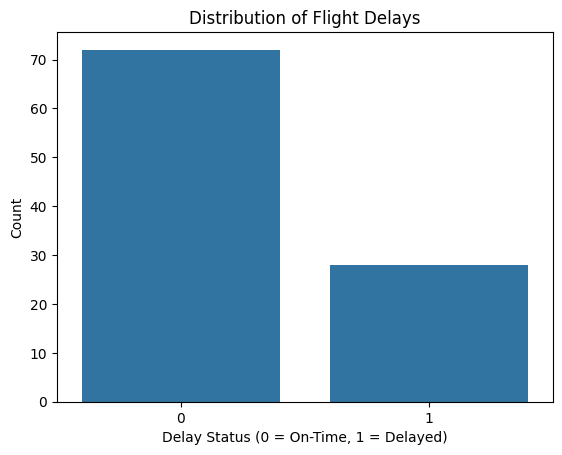

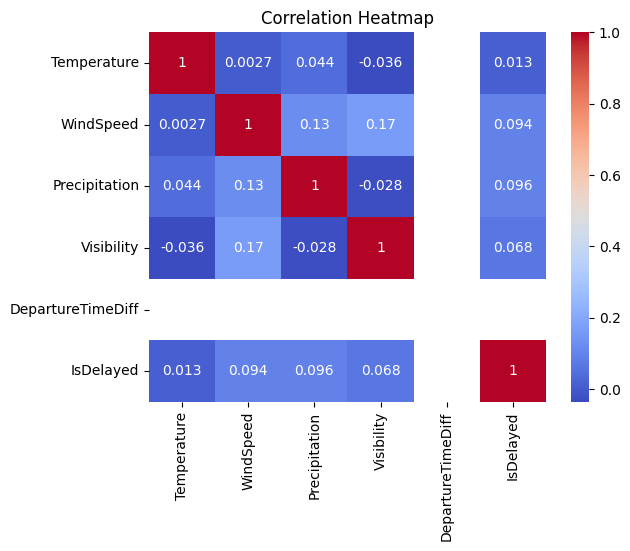

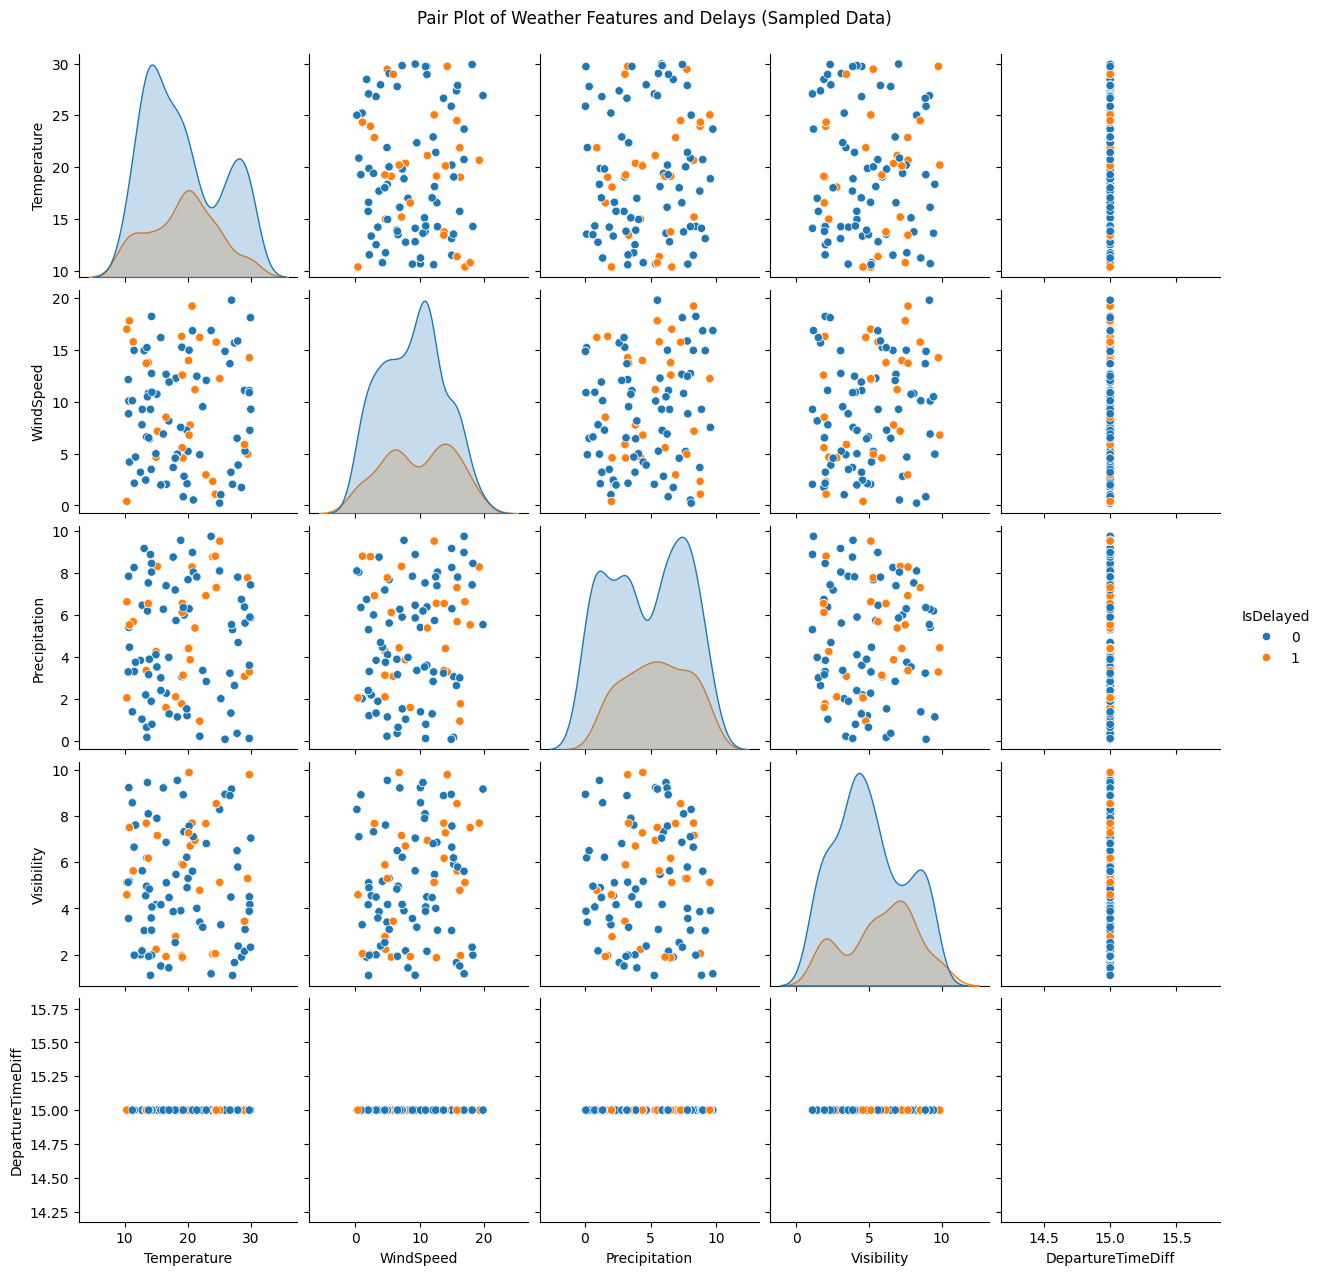

In [9]:
# Visualize the distribution of delays
sns.countplot(x="IsDelayed", data=merged_data)
plt.title("Distribution of Flight Delays")
plt.xlabel("Delay Status (0 = On-Time, 1 = Delayed)")
plt.ylabel("Count")
plt.show()

# Correlation heatmap
correlation_matrix = merged_data[features + ["IsDelayed"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Pair plot of features
# sample_data = merged_data.sample(500, random_state=42)  # Use a sample of 500 rows
# Use replace=True or sample a smaller number of rows
sample_data = merged_data.sample(n=100, random_state=42)  # Sample all 100 rows without replacement

#OR

sample_data = merged_data.sample(n=500, replace=True, random_state=42)  # Sample with replacement

sns.pairplot(sample_data, hue="IsDelayed", vars=features)
plt.suptitle("Pair Plot of Weather Features and Delays (Sampled Data)", y=1.02)
plt.show()


# Additional Weather Data Visualizations

1. Box Plot: Temperature vs. Delay Status
Visualize how temperature distributions vary between delayed and non-delayed flights.

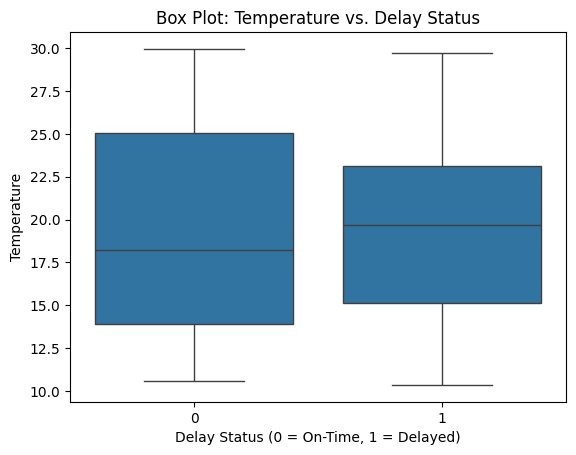

In [10]:
sns.boxplot(x="IsDelayed", y="Temperature", data=merged_data)
plt.title("Box Plot: Temperature vs. Delay Status")
plt.xlabel("Delay Status (0 = On-Time, 1 = Delayed)")
plt.ylabel("Temperature")
plt.show()


2.Bar Plot: Average Weather Conditions for Delayed and On-Time Flights
Compare the mean values of key weather features for delayed and on-time flights.

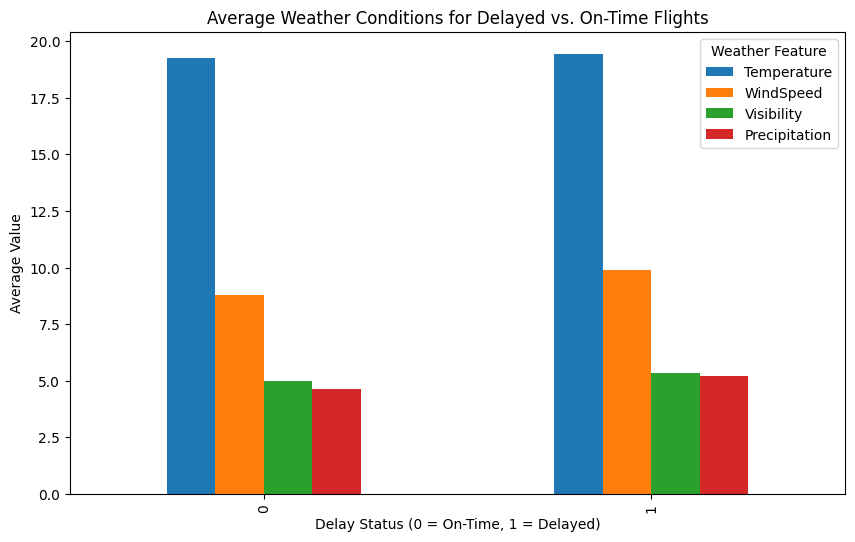

In [11]:
mean_weather = merged_data.groupby("IsDelayed")[["Temperature", "WindSpeed", "Visibility", "Precipitation"]].mean()
mean_weather.plot(kind="bar", figsize=(10, 6))
plt.title("Average Weather Conditions for Delayed vs. On-Time Flights")
plt.xlabel("Delay Status (0 = On-Time, 1 = Delayed)")
plt.ylabel("Average Value")
plt.legend(title="Weather Feature")
plt.show()


3. Histogram: Weather Features
Analyze the distributions of weather features like temperature and wind speed.

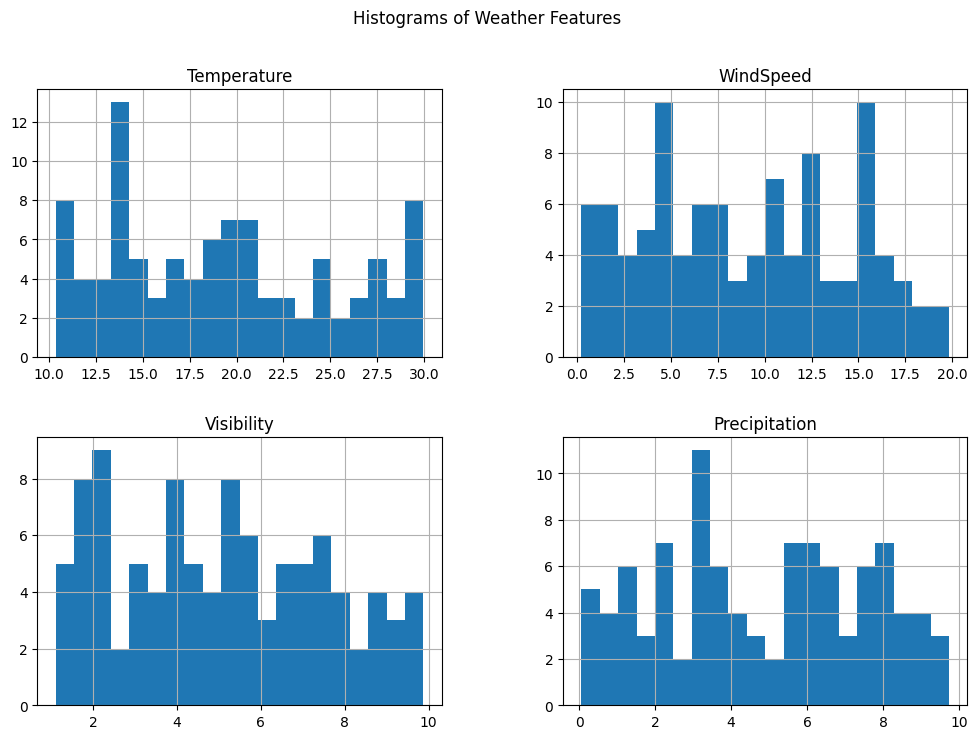

In [12]:
weather_features = ["Temperature", "WindSpeed", "Visibility", "Precipitation"]
merged_data[weather_features].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histograms of Weather Features")
plt.show()


4. Scatter Plot: Temperature vs. Wind Speed with Delay Status
Show the relationship between temperature and wind speed, colored by delay status.

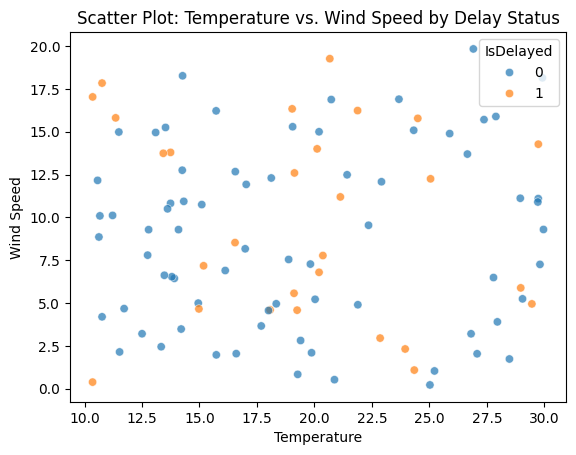

In [13]:
sns.scatterplot(data=merged_data, x="Temperature", y="WindSpeed", hue="IsDelayed", alpha=0.7)
plt.title("Scatter Plot: Temperature vs. Wind Speed by Delay Status")
plt.xlabel("Temperature")
plt.ylabel("Wind Speed")
plt.show()


6. Joint Plot: Visibility and Precipitation with Delay Status
Explore the relationship between visibility and precipitation and their effect on delays.

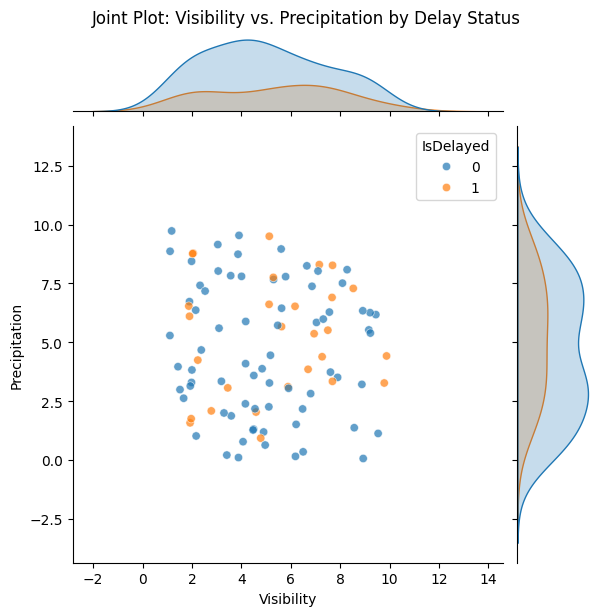

In [14]:
sns.jointplot(data=merged_data, x="Visibility", y="Precipitation", hue="IsDelayed", kind="scatter", alpha=0.7)
plt.suptitle("Joint Plot: Visibility vs. Precipitation by Delay Status", y=1.02)
plt.show()


7. Heatmap: Seasonal Weather Trends
Examine weather variations across different months and delay statuses.

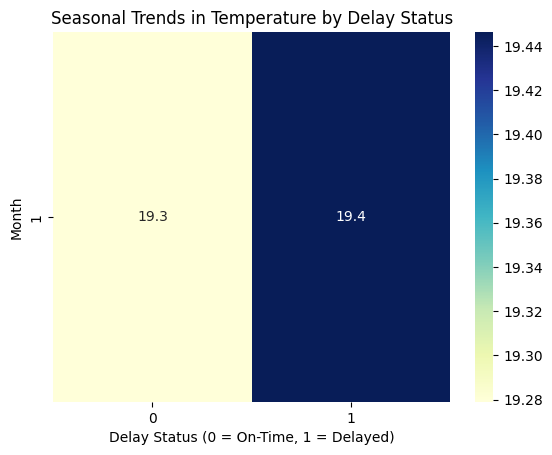

In [16]:
# Extract the month from the 'ScheduledDepartureTime' column
merged_data['Month'] = merged_data['ScheduledDepartureTime'].dt.month

# Now you can create the pivot table
seasonal_weather = merged_data.pivot_table(index="Month", columns="IsDelayed", values="Temperature", aggfunc="mean")

# The rest of your code should work as expected
sns.heatmap(seasonal_weather, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Seasonal Trends in Temperature by Delay Status")
plt.xlabel("Delay Status (0 = On-Time, 1 = Delayed)")
plt.ylabel("Month")
plt.show()

#  Model Building: Random Forest Classifier

In [ ]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predictions on test data
y_pred = model.predict(X_test)

# Model Evaluation

Accuracy: 0.7

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.33      0.20      0.25         5

    accuracy                           0.70        20
   macro avg       0.55      0.53      0.53        20
weighted avg       0.66      0.70      0.67        20

ROC AUC Score: 0.6533333333333333


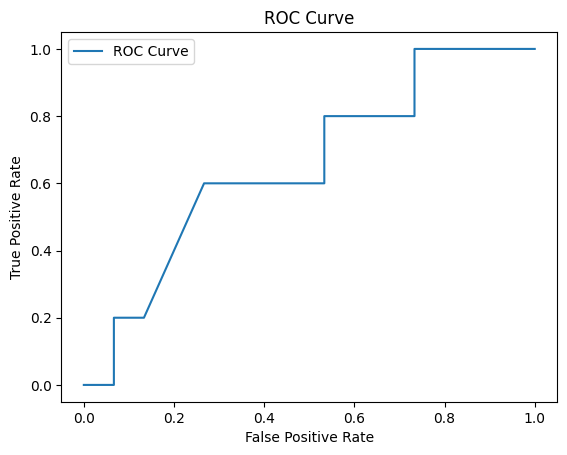

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# Select features and target
X = merged_data[["Temperature", "WindSpeed", "Precipitation", "Visibility"]]
y = merged_data["IsDelayed"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Incorporating Uncertainty: Monte Carlo Simulation

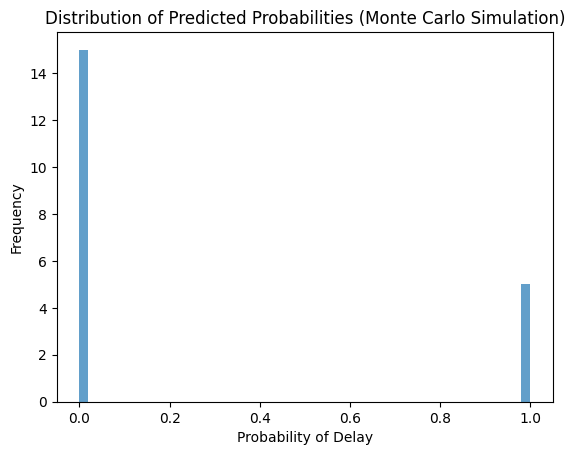

In [ ]:
# Monte Carlo Simulation for probabilistic predictions
np.random.seed(42)
n_simulations = 1000

# Introduce variability into weather features
simulated_data = X_test.copy()
simulated_data["Temperature"] += np.random.normal(0, 2, size=len(simulated_data))
simulated_data["WindSpeed"] += np.random.normal(0, 1, size=len(simulated_data))
simulated_data["Precipitation"] += np.random.normal(0, 0.1, size=len(simulated_data))

# Run simulations
simulated_predictions = [model.predict(simulated_data) for _ in range(n_simulations)]
simulated_probabilities = np.mean(simulated_predictions, axis=0)

# Visualize uncertainty
plt.hist(simulated_probabilities, bins=50, alpha=0.7)
plt.title("Distribution of Predicted Probabilities (Monte Carlo Simulation)")
plt.xlabel("Probability of Delay")
plt.ylabel("Frequency")
plt.show()


7. Discussion: Model's Performance and Improvements

Brier Score Loss (calibrated): 0.20551464142173645


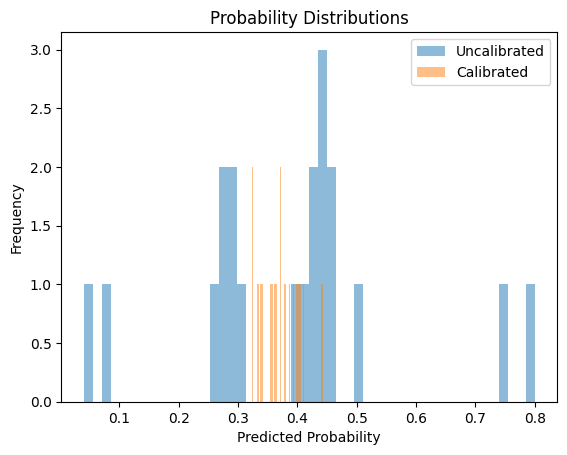

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# Calibrated Random Forest for uncertainty quantification
# Pass the model as the first argument instead of using base_estimator
calibrated_model = CalibratedClassifierCV(model, method="sigmoid")
calibrated_model.fit(X_train, y_train)

# Get probabilistic predictions
y_prob_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Evaluate Brier Score Loss
brier_score = brier_score_loss(y_test, y_prob_calibrated)
print("Brier Score Loss (calibrated):", brier_score)

# Compare calibrated and uncalibrated probabilities
plt.hist(y_prob, bins=50, alpha=0.5, label="Uncalibrated")
plt.hist(y_prob_calibrated, bins=50, alpha=0.5, label="Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Probability Distributions")
plt.legend()
plt.show()

## Discussion



### **Role of Uncertainty**
Monte Carlo simulations revealed the variability in predictions due to fluctuating weather conditions. This probabilistic approach highlights the impact of weather variability on predictions, offering insights beyond deterministic models.

### **Trade-offs Between Accuracy and Certainty**
While deterministic predictions were more certain, they lack flexibility. Probabilistic models provide more nuanced insights but can reduce confidence in individual predictions.

### **Potential Improvements**
1. **Additional Features:** Incorporate air traffic, seasonal trends, or day-of-week factors.
2. **Ensemble Models:** Use Bayesian models or deep learning for more robust predictions.
3. **Larger Datasets:** Increase data diversity to improve model generalization.
4. **Interpretability:** Use SHAP or LIME to understand feature contributions.